# Project: Investigate a Dataset - [TMDB Movie data]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id=intro></a>
## Introduction

### Dataset Description 

This data set contains information about 10,000 movies collected from The Movie Database (TMDb), including user ratings and revenue.

The data contains 21 columns of information about movies released from 1960 till 2015.

These columns include the following information: id, imdb_id, popularity, budget, revenue, original_title, cast, homepage, director, tagline, keywords, overview, runtime, genres, production_companies, release_date, vote_count, vote_average, release_year, budget_adj, revenue_adj


### Question(s) for Analysis

**Q1** Does the movies production values increase with time ?

**Q2** What are the most profitable genres for each decade ?

**Q3** Are movies with longer runtime more profitable than others ?

**Q4** Does the movie's release season affect its profit ?

**Q5** What are the best 3 movies for each decade ? (according to the available data)


In [1]:
# import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline


In [2]:
#upgrade pandas to use 'explode'
!pip install pandas==0.25.1

<a id='wrangling'></a>
## Data Wrangling


### General Properties
The following few cell blocks are used to explore the data and identify the columns to be used.

In [3]:
# Load your data and print out a few lines.
df = pd.read_csv('Database_TMDb_movie_data/tmdb-movies.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

In [4]:
df['release_year'].min(),df['release_year'].max()

(1960, 2015)

In [5]:
df['genres'].unique(),df['genres'].nunique()

(array(['Action|Adventure|Science Fiction|Thriller',
        'Adventure|Science Fiction|Thriller',
        'Action|Adventure|Science Fiction|Fantasy', ...,
        'Adventure|Drama|Action|Family|Foreign',
        'Comedy|Family|Mystery|Romance',
        'Mystery|Science Fiction|Thriller|Drama'], dtype=object), 2039)

In [6]:
df['popularity'].mean(),df['popularity'].min(),df['popularity'].max(),df['budget_adj'].min(),df['revenue_adj'].min()

(0.6464409519602429, 6.500000000000001e-05, 32.985763, 0.0, 0.0)

The popularity index varies by day, so propably it won't be a good indication to be used. (as per https://developers.themoviedb.org/3/getting-started/popularity)

We'll use the movie's profit as a measure for quality.

Also, the 'adjusted for inflation' values will be used throughout for consistency in comparison.


### Data Cleaning

**1-** Drop any unnecessary and incomplete columns.

we'll remove the zero-values from the budget and revenue columns since most of the analysis will be based on them.

In [7]:
#tips from
#https://stackoverflow.com/questions/45416684/python-pandas-replace-multiple-columns-zero-to-nan
#https://stackoverflow.com/questions/13851535/how-to-delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression

df.drop(df[(df['budget_adj']==0)|(df['revenue_adj']==0)].index,inplace=True)

Add the profit column.

In [8]:
#get the numbers in millions
df['revenue_adj'] = df['revenue_adj']/1000000
df['budget_adj'] = df['budget_adj']/1000000
df['profit'] = df['revenue_adj'] - df['budget_adj']

Drop columns that will not be used.

In [9]:
df.drop(['id', 'imdb_id', 'budget', 'popularity' , 'revenue',  'cast', 'homepage', 'director', 'tagline', 'keywords', 'overview', 'production_companies', 'vote_count', 'vote_average'], axis=1,inplace=True)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3855 entries, 0 to 10848
Data columns (total 8 columns):
original_title    3855 non-null object
runtime           3855 non-null int64
genres            3855 non-null object
release_date      3855 non-null object
release_year      3855 non-null int64
budget_adj        3855 non-null float64
revenue_adj       3855 non-null float64
profit            3855 non-null float64
dtypes: float64(3), int64(2), object(3)
memory usage: 271.1+ KB


**2-** Convert release_date to datetime, then add decade and season columns

Add full release year to the release_date column to bypass Python's year issue for dates before 1969
https://docs.python.org/2/library/time.html

In [10]:
df['release_date'] = df['release_date'].str[:-2] + df['release_year'].astype(str)

In [11]:
#tips from:
#https://stackoverflow.com/questions/17764619/pandas-dataframe-group-year-index-by-decade
#https://stackoverflow.com/questions/60285557/extract-seasons-from-datetime-pandas

df['release_date'] = pd.to_datetime(df['release_date'],format="%m/%d/%Y")
df['decade'] = df['release_year'].apply(lambda x: x//10*10)
df['date_offset'] = (df.release_date.dt.month*100 + df.release_date.dt.day - 320)%1300
df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], labels=['spring', 'summer', 'autumn', 'winter'],include_lowest = True)
df.drop('date_offset',axis=1,inplace=True)

df[['release_date','decade','season']].tail() #just for checking

,release_date,decade,season
10822,1966-06-21,1960,summer
10828,1966-07-13,1960,summer
10829,1966-12-17,1960,autumn
10835,1966-12-20,1960,autumn
10848,1966-08-24,1960,summer


In [12]:
df['decade'].value_counts()

2000    1460
2010    1041
1990     755
1980     395
1970     133
1960      71
Name: decade, dtype: int64

It is clear that the database contains much more data for the recent years compared to the earlier ones.

**3-** Adjust the genres column for consistency

In order to account for the different genres for each movie, we'll use a dataframe specific for genres analysis where each movie's many genres are 'exploded' into multiple rows.

In [13]:
#tip from the review as per https://www.geeksforgeeks.org/convert-list-like-column-elements-to-separate-rows-in-pandas/
genres_df = df.assign(genres=df['genres'].str.split('|')).explode('genres')
genres_df.head(8)

,original_title,runtime,genres,release_date,release_year,budget_adj,revenue_adj,profit,decade,season
0,Jurassic World,124,Action,2015-06-09,2015,137.999939,1392.445893,1254.445953,2010,spring
0,Jurassic World,124,Adventure,2015-06-09,2015,137.999939,1392.445893,1254.445953,2010,spring
0,Jurassic World,124,Science Fiction,2015-06-09,2015,137.999939,1392.445893,1254.445953,2010,spring
0,Jurassic World,124,Thriller,2015-06-09,2015,137.999939,1392.445893,1254.445953,2010,spring
1,Mad Max: Fury Road,120,Action,2015-05-13,2015,137.999939,348.161292,210.161353,2010,spring
1,Mad Max: Fury Road,120,Adventure,2015-05-13,2015,137.999939,348.161292,210.161353,2010,spring
1,Mad Max: Fury Road,120,Science Fiction,2015-05-13,2015,137.999939,348.161292,210.161353,2010,spring
1,Mad Max: Fury Road,120,Thriller,2015-05-13,2015,137.999939,348.161292,210.161353,2010,spring


<a id='eda'></a>
## Exploratory Data Analysis


Since a lot of ploting will be involved, we'll define a function for labeling the axes and the title.

In [14]:
def plt_txt(xplt, yplt, gtitle):
    '''a simple function to be called after ploting to pass the axes and title labels'''
    plt.xlabel(xplt,weight = "bold")
    plt.ylabel(yplt,weight = "bold")
    plt.title(gtitle,weight = "bold")

### Q1 - Does the movies production values increase with time ?

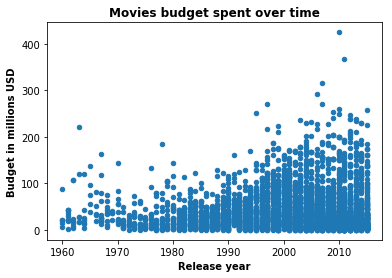

In [15]:
df.plot.scatter(x='release_year',y='budget_adj');
#plt.ylabel('Budget in millions USD');
plt_txt('Release year','Budget in millions USD','Movies budget spent over time')

The above figure indicates that the Movie production business has been growing steadily with time.

let's try to plot the mean of each year to better get the feel for the numbers.

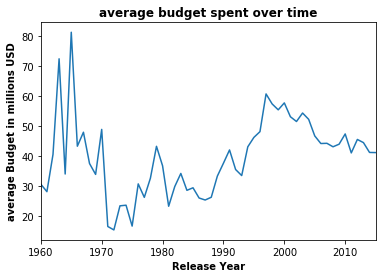

In [16]:
df.groupby('release_year').mean()['budget_adj'].plot.line();
plt_txt('release year'.title(),'average Budget in millions USD','average budget spent over time')

Due to the shortage in the availabe data for older years, we cannot guarantee for sure that the movie production industry is growing with time. We'll need more data for better observation.

### Q2 - What are the most profitable genres for each decade ?

First, we'll show the order of the most popular genres for all the dataset.

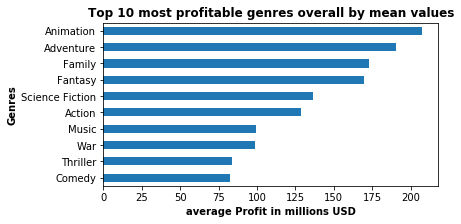

In [17]:
#tips from https://stackoverflow.com/questions/54250254/pandas-groupby-plotting-each-group
#https://stackoverflow.com/questions/20069009/pandas-get-topmost-n-records-within-each-group

genres_df.groupby('genres')['profit'].mean().nlargest(10).sort_values().plot.barh(figsize=(6, 3));
plt_txt('average Profit in millions USD','Genres','Top 10 most profitable genres overall by mean values');

Next, we'll explore the most profitable genres by decade by using the excellent **.unstack** method.

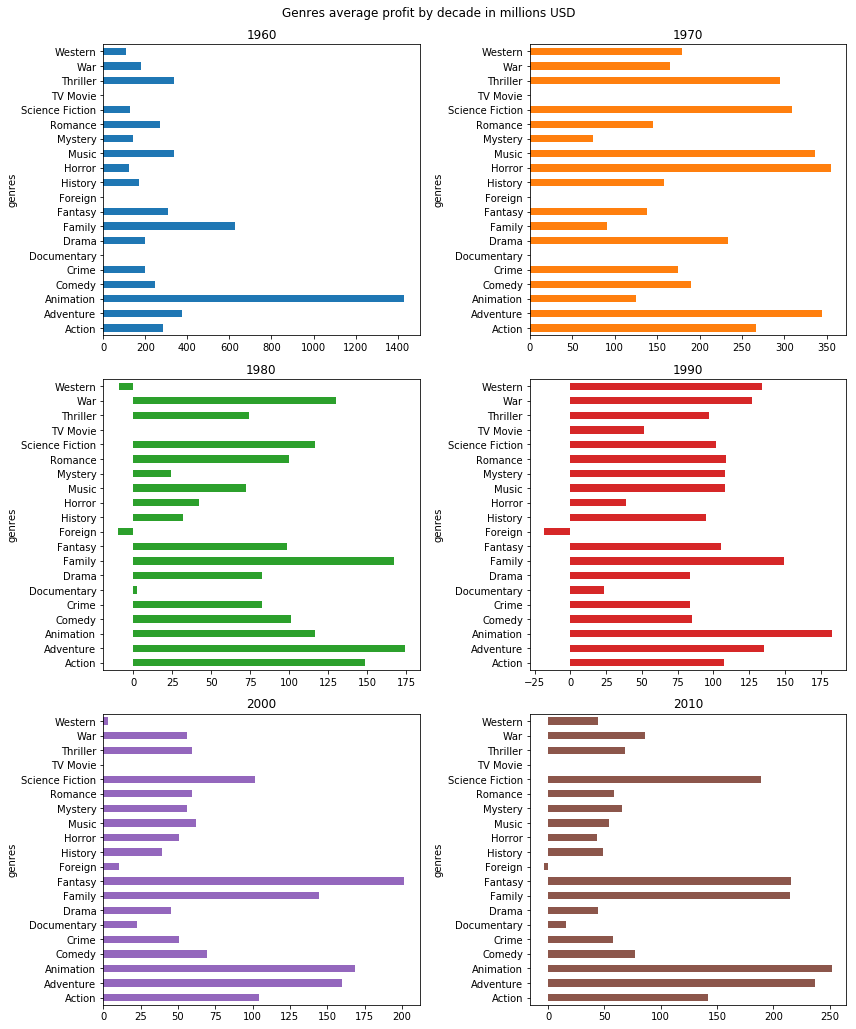

In [18]:
#another method can be used by looping: https://engineeringfordatascience.com/posts/matplotlib_subplots/

genres_df.groupby(['decade','genres'])['profit'].mean().unstack('decade').plot.barh(
    subplots=True,layout=(3,2),figsize=(12,15),sharex=False,legend=False,rot=0,title='Genres average profit by decade in millions USD');
plt.tight_layout(rect=[0, 0.03, 1, 0.97]) #[left, bottom, right, top] in normalized (0, 1) figure coordinates

In [19]:
genres_df[(genres_df['decade']==1960) & (genres_df['genres']=='Animation')]

,original_title,runtime,genres,release_date,release_year,budget_adj,revenue_adj,profit,decade,season
10110,One Hundred and One Dalmatians,79,Animation,1961-01-25,1961,29.179445,1574.814740,1545.635295,1960,winter
10398,The Jungle Book,78,Animation,1967-10-18,1967,26.147055,1345.551059,1319.404004,1960,autumn


**We can see from the above figures that one misleading entry can cause a misinterpretation of the dataset.** (As shown in 1960 data)

Nevertheless, the 'Animation' category seems to have been very popular in the 60's (thanks to 2 movies in particular) and remains to be throughout the years.

### Q3 Are movies with longer runtime more profitable than others ?

We'll consider (movies > 2 hrs) to be long, while (2 hrs > movies >= 1.5 hrs) to be medium ,and (1.5 hrs > movies) to be short.

In [20]:
df['m_length'] = pd.cut(df['runtime'], [0, 90, 120, 900], labels=['short', 'medium', 'long'])

Let's check the percentages of the movies in the database by duration.

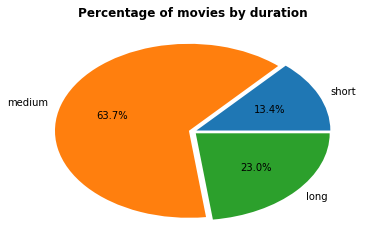

In [21]:
df.groupby('m_length').count()['profit'].plot.pie(startangle=0,autopct='%1.1f%%',fontsize=10,explode=(0.03, 0.03, 0.03));
plt_txt('','','Percentage of movies by duration');

Now, let's check the profits against duration.

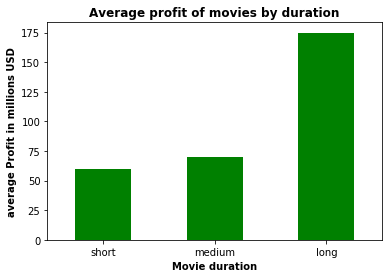

In [22]:
df.groupby('m_length').mean()['profit'].plot.bar(rot=0,color='g');
plt_txt('Movie duration','average Profit in millions USD','Average profit of movies by duration')

It is evident that longer movies in general get higher profits. 

It is noted that the dataset contains some movies with zero runtime and others with illogical values (900 mins runtime), which will affect the accurecy of the analysis outcome and might require further investigation.

### Q4 Does the movie's release season affect its profit ?

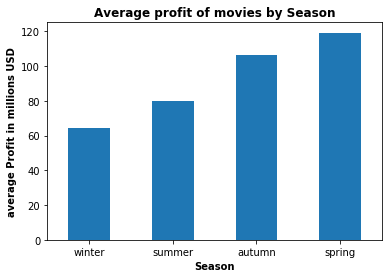

In [23]:
df.groupby('season').mean()['profit'].sort_values().plot.bar(rot=0);
plt_txt('Season',"average Profit in millions USD",'Average profit of movies by Season');

It appears that the release season does affect the potenial for higher profits.

### Q5 What are the best 3 movies for each decade ? (according to the available data)

In [24]:
df2 = df.groupby('decade')['profit'].nlargest(3)

In [25]:
for i in sorted(list((df['decade'].unique()))):
    mo = []
    l = list(df2.loc[i].index)
    for j in l:
        mo.append(df.loc[j]['original_title'])
    print('The best movies of the {}s are:\n   1st:{}\n   2nd:{}\n   3rd:{}'.format(str(i),mo[0],mo[1],mo[2]))
    print('*'*40)

The best movies of the 1960s are:
   1st:One Hundred and One Dalmatians
   2nd:The Jungle Book
   3rd:The Sound of Music
****************************************
The best movies of the 1970s are:
   1st:Star Wars
   2nd:The Exorcist
   3rd:Jaws
****************************************
The best movies of the 1980s are:
   1st:E.T. the Extra-Terrestrial
   2nd:The Empire Strikes Back
   3rd:Return of the Jedi
****************************************
The best movies of the 1990s are:
   1st:Titanic
   2nd:The Net
   3rd:Jurassic Park
****************************************
The best movies of the 2000s are:
   1st:Avatar
   2nd:The Lord of the Rings: The Return of the King
   3rd:Harry Potter and the Philosopher's Stone
****************************************
The best movies of the 2010s are:
   1st:Star Wars: The Force Awakens
   2nd:Jurassic World
   3rd:The Avengers
****************************************


<a id='conclusions'></a>
## Conclusions

We started with a dataset of more than 10,000 entries, and ended up using around 3,500 of them only. This number of entries is considered suffiecient to draw wide observations about the Movie industry, but not to take a business decesion about it.

Due to the nature of the origin data, we couldn't account of any outliers. Which means that Movies that perform exceptionally well in profit values will affect the analysis outcome.

The sample data used is not evenly distributed among the years, which might result in a biased outcome.

Since each movie in the dataset has different number of genres, one movie will influence many genres in the analysis, while another will not.

No statistical inference analysis was performed on the data to test the significance of the results.


**Based on the above questions we can conclude the following points:**

>-It seems that the movies production budget is growing with time, but due to the shortage in the availabe data for the older years, we cannot guarantee that fact for sure. We'll need more data for better observation.

>-In general, the 'Adventure' and 'Animation' genres are highly popular and profitable.

>-It is better to produce movies with longer runtime that have solid storytelling elements.

>-It is better to release a movie in spring season for a better crowd attendance.

## Submitting your Project 

In [26]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0